# Base Models for Total Lean Mass and Total Fat Mass Prediction

In [1]:
import os
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

## Load Test Data
Load the test dataset used to evaluate the primary model. To ensure a fair and consistent comparison, the same test data will be used for evaluating both the primary and baseline models.

In [2]:
test_path = "data/test.csv"

if not os.path.exists(test_path):
    raise FileNotFoundError(f"Test Set not found at {test_path}. Ensure the preprocessing step was completed.")

test = pd.read_csv(test_path)
print(f"Dataset loaded successfully. Shape: {test.shape}")

test.head()

Dataset loaded successfully. Shape: (4596, 18)


,id,weight,height,bmi,upper_leg_length,maximal_calf_circumference,upper_arm_length,arm_circumference,waist_circumference,thigh_circumference,gender,age_in_months,ethnicity,total_fat_mass,total_lean_mass,age_group,bmi_group,stratify_group
0,30864.0,102.7,186.9,29.40,50.7,39.1,42.5,39.6,108.9,56.4,1.0,583.0,4.0,27980.7,76264.1,46-56,Overweight,46-56_1.0_4.0_Overweight
1,7504.0,67.5,170.2,23.30,45.3,36.8,36.7,29.2,72.0,52.5,1.0,206.0,4.0,13619.7,54868.6,16-26,Healthy Weight,16-26_1.0_4.0_Healthy Weight
2,12659.0,59.6,160.7,23.08,39.7,35.9,35.7,28.7,75.9,53.0,2.0,608.0,3.0,18858.1,40932.8,46-56,Healthy Weight,46-56_2.0_3.0_Healthy Weight
3,22997.0,56.0,179.2,17.44,41.0,33.3,38.8,25.1,70.1,44.5,1.0,264.0,3.0,9735.0,46648.0,16-26,Underweight,16-26_1.0_3.0_Underweight
4,8392.0,69.8,168.1,24.70,39.0,38.4,39.5,30.9,93.2,47.8,1.0,635.0,5.0,22189.3,48741.1,46-56,Healthy Weight,46-56_1.0_5.0_Healthy Weight


## Define the Base Models for TLM Prediction (Boer, James and Hume formulas)

In [3]:
def boer_formula(weight, height, gender):
    """
    Estimate lean body mass using the Boer formula. Returns weight in g.
    Parameters:
        weight: Weight in kg.
        height: Height in cm.
        gender: 'Male' or 'Female'
    Returns:
        Estimated lean body mass.
    """
    if gender.lower() == 'male':
        return 1000*(0.407 * weight + 0.267 * height - 19.2)
    else:
        return 1000*(0.252 * weight + 0.473 * height - 48.3)

def james_formula(weight, height, gender):
    """
    Estimate lean body mass using the James formula. Returns weight in g.
    """
    if gender.lower() == 'male':
        return 1000*(1.1 * weight - 128 * (weight / height)**2)
    else:
        return 1000*(1.07 * weight - 148 * (weight / height)**2)

def hume_formula(weight, height, gender):
    """
    Estimate lean body mass using the Hume formula. Returns weight in g.
    """
    if gender.lower() == 'male':
        return 1000*(0.32810 * weight + 0.33929 * height - 29.5336)
    else:
        return 1000*(0.29569 * weight + 0.41813 * height - 43.2933)


## Predict the TLM values based on defined formulas

In [4]:
test['tlm_boer'] = test.apply(
    lambda row: boer_formula(row['weight'], row['height'], 'male' if row['gender'] == 1 else 'female'), axis=1
)
test['tlm_james'] = test.apply(
    lambda row: james_formula(row['weight'], row['height'], 'male' if row['gender'] == 1 else 'female'), axis=1
)
test['tlm_hume'] = test.apply(
    lambda row: hume_formula(row['weight'], row['height'], 'male' if row['gender'] == 1 else 'female'), axis=1
)

print("Dummy model predictions computed for Boer, James, and Hume formulas.")
test[['weight', 'height', 'gender', 'tlm_boer', 'tlm_james', 'tlm_hume']].head()


Dummy model predictions computed for Boer, James, and Hume formulas.


,weight,height,gender,tlm_boer,tlm_james,tlm_hume
0,102.7,186.9,1.0,72501.2,74321.534613,67575.571
1,67.5,170.2,1.0,53715.9,54117.467733,50360.308
2,59.6,160.7,2.0,42730.3,43414.591974,41523.315
3,56.0,179.2,1.0,51438.4,49100.000000,49640.768
4,69.8,168.1,1.0,54091.3,54710.861103,50402.429


## Calculate the evaluation metrics for TLM
For every formula, we calculated the Pearson correlation and SEE to compare base models with the results of ML Model. Visualizing the predicted and true data.

Pearson correlation (Boer): 0.961
SEE (Boer): 3799.240
Pearson correlation (James): 0.941
SEE (James): 4397.715
Pearson correlation (Hume): 0.953
SEE (Hume): 4575.630


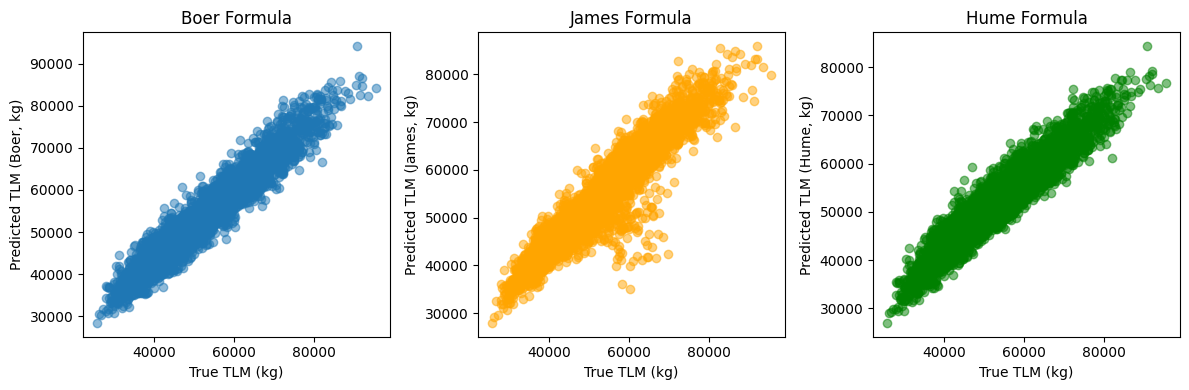

In [5]:
if 'total_lean_mass' in test.columns:
    true_tlm = test['total_lean_mass'] 

    # Calculating Pearson correlation
    corr_boer, _ = pearsonr(true_tlm, test['tlm_boer'])
    corr_james, _ = pearsonr(true_tlm, test['tlm_james'])
    corr_hume, _ = pearsonr(true_tlm, test['tlm_hume'])

    # Calculating SEE
    errors_boer = true_tlm - test['tlm_boer']
    errors_james = true_tlm - test['tlm_james']
    errors_hume = true_tlm - test['tlm_hume']

    see_boer = np.sqrt(np.mean(errors_boer ** 2))
    see_james = np.sqrt(np.mean(errors_james ** 2))
    see_hume = np.sqrt(np.mean(errors_hume ** 2))

    print(f"Pearson correlation (Boer): {corr_boer:.3f}")
    print(f"SEE (Boer): {see_boer:.3f}")
    print(f"Pearson correlation (James): {corr_james:.3f}")
    print(f"SEE (James): {see_james:.3f}")
    print(f"Pearson correlation (Hume): {corr_hume:.3f}")
    print(f"SEE (Hume): {see_hume:.3f}")

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.scatter(true_tlm, test['tlm_boer'], alpha=0.5)
    plt.xlabel("True TLM (kg)")
    plt.ylabel("Predicted TLM (Boer, kg)")
    plt.title("Boer Formula")

    plt.subplot(1, 3, 2)
    plt.scatter(true_tlm, test['tlm_james'], alpha=0.5, color='orange')
    plt.xlabel("True TLM (kg)")
    plt.ylabel("Predicted TLM (James, kg)")
    plt.title("James Formula")

    plt.subplot(1, 3, 3)
    plt.scatter(true_tlm, test['tlm_hume'], alpha=0.5, color='green')
    plt.xlabel("True TLM (kg)")
    plt.ylabel("Predicted TLM (Hume, kg)")
    plt.title("Hume Formula")

    plt.tight_layout()
    plt.show()
else:
    print("The dataset does not contain 'total_lean_mass'. Evaluation cannot be performed.")


## Define the Base Model for TFM Prediction (BMI Formula)

In [6]:
def bfp_bmi_method(bmi, age, gender):
    """
    Estimate body fat percentage using the BMI method.
    """
    if gender.lower() == 'male':
        return (1.20 * bmi + 0.23 * age - 16.2) / 100
    else:
        return (1.20 * bmi + 0.23 * age - 5.4) / 100

## Predict the TFM values based on defined formula

In [7]:
test['bfp_bmi'] = test.apply(
    lambda row: bfp_bmi_method(row['bmi'], row['age_in_months']/12, 'male' if row['gender'] == 1 else 'female'),
    axis=1
)

test['tfm_bmi'] = test['bfp_bmi'] * test['weight'] * 1000

test.head()

,id,weight,height,bmi,upper_leg_length,maximal_calf_circumference,upper_arm_length,arm_circumference,waist_circumference,thigh_circumference,...,total_fat_mass,total_lean_mass,age_group,bmi_group,stratify_group,tlm_boer,tlm_james,tlm_hume,bfp_bmi,tfm_bmi
0,30864.0,102.7,186.9,29.40,50.7,39.1,42.5,39.6,108.9,56.4,...,27980.7,76264.1,46-56,Overweight,46-56_1.0_4.0_Overweight,72501.2,74321.534613,67575.571,0.302542,31071.029167
1,7504.0,67.5,170.2,23.30,45.3,36.8,36.7,29.2,72.0,52.5,...,13619.7,54868.6,16-26,Healthy Weight,16-26_1.0_4.0_Healthy Weight,53715.9,54117.467733,50360.308,0.157083,10603.125000
2,12659.0,59.6,160.7,23.08,39.7,35.9,35.7,28.7,75.9,53.0,...,18858.1,40932.8,46-56,Healthy Weight,46-56_2.0_3.0_Healthy Weight,42730.3,43414.591974,41523.315,0.339493,20233.802667
3,22997.0,56.0,179.2,17.44,41.0,33.3,38.8,25.1,70.1,44.5,...,9735.0,46648.0,16-26,Underweight,16-26_1.0_3.0_Underweight,51438.4,49100.000000,49640.768,0.097880,5481.280000
4,8392.0,69.8,168.1,24.70,39.0,38.4,39.5,30.9,93.2,47.8,...,22189.3,48741.1,46-56,Healthy Weight,46-56_1.0_5.0_Healthy Weight,54091.3,54710.861103,50402.429,0.256108,17876.361667


## Calculate the evaluation metrics for TFM
We calculated the Pearson correlation and SEE to compare base model with the results of ML Model. Visualizing the predicted and true data.

Pearson correlation (TFM - BMI Method): 0.950
SEE (TFM - BMI Method): 4527.269


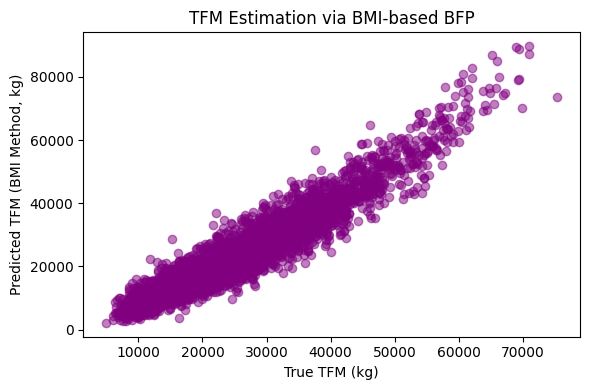

In [8]:
if 'total_fat_mass' in test.columns:
    true_tfm = test['total_fat_mass']

    # Pearson correlation
    corr_tfm = pearsonr(true_tfm, test['tfm_bmi'])[0]

    # SEE
    errors_tfm = true_tfm - test['tfm_bmi']
    see_tfm = np.sqrt(np.mean(errors_tfm ** 2))

    print(f"Pearson correlation (TFM - BMI Method): {corr_tfm:.3f}")
    print(f"SEE (TFM - BMI Method): {see_tfm:.3f}")

    # Plot
    plt.figure(figsize=(6, 4))
    plt.scatter(true_tfm, test['tfm_bmi'], alpha=0.5, color='purple')
    plt.xlabel("True TFM (kg)")
    plt.ylabel("Predicted TFM (BMI Method, kg)")
    plt.title("TFM Estimation via BMI-based BFP")
    plt.tight_layout()
    plt.show()
else:
    print("The dataset does not contain 'total_fat_mass'. Evaluation cannot be performed.")